# EDA - Tag/Similarity Analysis
The purpose of this notebook is to compare different approaches to quantifying game similarity based on user-assigned tags.

## Abstract
The approaches being compared are:
- Hamming distance (really, an analog thereof)
- Euclidean distance
- Manhattan distance (post-PCA)
- Cosine distance

Ultimately, I found that cosine similarity was the best approach because:
- The distribution of cosine distances (all games vs one) aligned with my expectation that most games should be dissimilar 
- The five games with the lowest cosine distance (to some reference game) are at least as good a match as the five with the lowest Hamming, Euclidean, or Manhattan distances, in my opinion
- The rankings of cosine distances for certain game pairs best aligned with my own judgement

__NB: In this notebook, the terms "distance" and "similarity" are not interchangeable:__ "distances" are objective, quantitative metrics I'm using to attempt describing "similarity," which is qualitative and even subjective.

## 0. Code Set-Up
This section doesn't contain analysis. Here I just
1. Import functions
2. Set reasonable style defaults
3. Import data
4. Apply PCA (for Manhattan approach)
5. Define convenience functions & variables

### 0.1 - Imports

In [18]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cuml import PCA
from cuml.metrics.pairwise_distances import pairwise_distances
from IPython.display import Markdown, display, display_html, display_markdown

### 0.2 - Style config

In [2]:
# Configure style
plt.style.use("petroff10")
sns.set_style("whitegrid")

### 0.3 - Load Data

In [3]:
# Loads relevant data
df_games = pd.read_parquet("../../data/store_info.parquet")
df_tags = pd.read_parquet("../../data/tags.parquet")
df_tags_binned = pd.read_parquet("../../data/tags_binned.parquet").astype(int)

### 0.4 PCA

In [4]:
# Applies PCA to tags DataFrame
df_tags_PCA = PCA(n_components=df_tags.shape[1]).fit_transform(df_tags)

### 0.5 - Variable & Function Definitions

In [5]:
# Instantiates dictionary for easy mapping of game names to appids
dict_appids = df_games["name"].to_dict()
dict_appids = {dict_appids[key]: key for key in dict_appids.keys()}

In [6]:
# Function to compute game similarities


def get_distances(reference_name: str) -> pd.DataFrame:
    """Generates DataFrame of game similarities to some reference game based on their tags.
    Three approaches are used: Hamming distance*, Euclidean distance, and cosine similarity.
    *I'm using the term "Hamming distance" as a convenient analogy; mathematically I'm calculating the number of tags that differ between games.
    Whereas the Euclidean and cosine approaches use tag "importances"  from zero to one, (see ingest_tags.ipynb), Hamming distance considers tag assignments to be boolean (i.e., all assigned tags are presumed to be equally important).

    Args:
        reference_name (str): Name of reference game. Must be present in database.

    Returns:
        pd.DataFrame: Game normalized distances to reference game. Normalized such that the most similar game (by definition, the reference itself) has a score of 1, and the least similar game has a score of 0.
    """

    # Gets appid of reference game
    reference_appid = dict_appids[reference_name]

    # Calculates "Hamming distance" of games from reference game, based on tags (boolean)
    # Mathematically, calculates the number of tags difference between reference game and all games,
    # assuming valid tag assignments to be equally important (i.e., tags are booleans)
    distances_hamming = (
        abs(df_tags_binned - df_tags_binned.loc[reference_appid]).transpose().sum()
    )

    # Calculates Euclidean distance of games from reference game, based on tags (continuous 0-1)
    distances_euclid = pairwise_distances(
        df_tags, df_tags.loc[reference_appid].values.reshape(1, -1), metric="euclidean"
    )

    # Calculates manhattan distance of all games to reference game, based on PCA-transformed continuous tags
    distances_manhattan = pairwise_distances(
        df_tags_PCA,
        df_tags_PCA.loc[reference_appid].values.reshape(1, -1),
        metric="manhattan",
    )

    # Calculates cosine distance of all games to reference game, based on PCA-transformed continuous tags
    # Cosine distance is kind of the opposite of cosine similarity:
    #   whereas cosine similarity goes from -1 (least similar) to 1,
    #   cosine distance (at least, in cuml) goes from 0 (most similar) to 1 (least similar)...

    distances_cosine = pairwise_distances(
        df_tags,
        df_tags.loc[reference_appid].values.reshape(1, -1),
        metric="cosine",
    )

    # Normalizes distances from 0 (closest) to 1 (farthest)
    distances_hamming = distances_hamming / distances_hamming.max()
    distances_euclid = distances_euclid / distances_euclid.max()
    distances_manhattan = distances_manhattan / distances_manhattan.max()
    distances_cosine = distances_cosine / distances_cosine.max()

    # Uses appids as series indices (Hamming implementation only uses Pandas so everything is already appropriately indexed)
    distances_euclid.index = df_tags.index
    distances_manhattan.index = df_tags_PCA.index
    distances_cosine.index = df_tags.index

    # Packages distance series into DataFrame
    df_distances = pd.DataFrame(
        {
            "Hamming": distances_hamming,
            "Euclidean": distances_euclid,
            "Manhattan (PCA)": distances_manhattan,
            "Cosine": distances_cosine,
        }
    )

    return df_distances

In [7]:
# Function to plot game similarities


def plot_similarities(df_distances: pd.DataFrame):
    """Convenience function to plot distribution of game similarities to some reference game from input DataFrame.

    Args:
        df_distances (pd.DataFrame): DataFrame of game normalized distances to some reference game. Generated by get_distances.
    """

    # Gets reference game (by definition, this should be the most similar. It's pretty unlikely that any two games's tags are an exact match...)
    #   Gets reference appid
    reference_appid = df_distances["Cosine"].sort_values().index[0]
    #   Gets reference name
    reference_name = df_games.loc[reference_appid]["name"]

    # Drops reference game prior to plotting (effectively hides useless points at similarity = 1)
    df_distances = df_distances.drop(reference_appid)

    # Melts DataFrame for Seaborn compatibility
    df_distances_melted = df_distances.melt(
        var_name="Approach", value_name="Normalized Distance"
    )

    # Draws violin plot. Split is set to true because what I really want is parallel histograms...
    sns.violinplot(
        df_distances_melted, y="Approach", x="Normalized Distance", split=True
    )
    # Plot formatting
    plt.xlim((0, 1))
    plt.title(f"Per-Approach Distributions of Game Distances from {reference_name}")
    plt.show()

In [8]:
# Function to get 5 most similar games (and associated normalized distances) from each approach


def get_similar_games(df_distances: pd.DataFrame, do_show_distances=False):
    """Displays top 5 most similar games to some reference game, as calculated by three approaches. Optionally shows associated normalized distances.

    Args:
        df_distances (pd.DataFrame): DataFrame of game normalized distances to some reference game. Generated by get_distances.
        do_show_distances (bool, optional): whether or not to visualize distances of top 5 games.
    """

    # Gets reference game (by definition, this should be the most similar. It's pretty unlikely that any two games's tags are an exact match...)
    #   Gets reference appid
    reference_appid = df_distances["Cosine"].sort_values().index[0]
    #   Gets reference name
    reference_name = df_games.loc[reference_appid]["name"]

    # Drops reference game prior to sorting
    df_distances = df_distances.drop(reference_appid)

    # Creates empty DataFrame to compare top 5 most similar games from each approach
    df_approach_comparison_games = pd.DataFrame()

    # Adds a column to game comparison DataFrame from each approach; values are game appids
    df_approach_comparison_games["Hamming"] = (
        df_distances["Hamming"].sort_values()[:5].index
    )
    df_approach_comparison_games["Euclidean"] = (
        df_distances["Euclidean"].sort_values()[:5].index
    )
    df_approach_comparison_games["Manhattan (PCA)"] = (
        df_distances["Manhattan (PCA)"].sort_values()[:5].index
    )
    df_approach_comparison_games["Cosine"] = (
        df_distances["Cosine"].sort_values()[:5].index
    )

    # Associates each game in game comparison with an integer so that the comparison table can color each cell based on what game is in it
    #   (making it easier to tell at a glance which games appear in multiple cells)
    gmap_mapping = {
        x: i for i, x in enumerate(set(df_approach_comparison_games.values.flatten()))
    }

    # Selects an appropriate colormap based on the number of games (sadly, none is especially accessible...)
    if len(gmap_mapping) <= 10:
        cmap = "tab10"
    elif len(gmap_mapping) <= 20:
        cmap = "tab20"
    else:
        cmap = "turbo"

    # Displays top 5 most similar games per approach
    display(Markdown(f"### Top 5 Games like {reference_name} (per-Approach)"))
    display(
        Markdown(
            # Replaces game appids with names
            df_approach_comparison_games.replace(df_games["name"])
            .style.background_gradient(
                # Uses earlier mapping to assign each game a unique color
                gmap=df_approach_comparison_games.replace(gmap_mapping),
                axis=None,
                cmap=cmap,
            )
            .to_html()
        )
    )

    if do_show_distances:

        # Creates empty DataFrame to compare normalized distances of 5 most similar games from each approach
        df_approach_comparison_scores = pd.DataFrame()

        # Adds column to score comparison DataFrame from each approach; values are normalized distances
        df_approach_comparison_scores["Hamming"] = (
            df_distances["Hamming"].sort_values()[:5].values
        )
        df_approach_comparison_scores["Euclidean"] = (
            df_distances["Euclidean"].sort_values()[:5].values
        )
        df_approach_comparison_scores["Manhattan (PCA)"] = (
            df_distances["Manhattan (PCA)"].sort_values()[:5].values
        )
        df_approach_comparison_scores["Cosine"] = (
            df_distances["Cosine"].sort_values()[:5].values
        )

        # Displays normalized distances of top 5 most similar games per approach
        display(Markdown(f"### Lowest 5 Normalized Distances (per-Approach)"))
        display(
            Markdown(
                df_approach_comparison_scores.style.background_gradient(
                    cmap="viridis_r", vmin=0, vmax=1
                )
                .format(precision=2)
                .to_html()
            )
        )

## 1. Background
### Motivation
It is self-evident that knowledge of media similarity should inform media recommendations; however, media similarity cannot be determined objectively. As a heuristic, we can look at the language people use to describe media--in this case, tags. We can reasonably assume that games with more tags in common should be more similar, so the question becomes: how can we quantify how similar games tags are?

### Dataset
Steam users can assign tags to games; from the number of these assignments, we can infer how much that tag matters to the population of Steam users. For every game, each of the 446 tags has been given an importance from 0 to 1 based on the number of assignments (see ingest_tags notebook).

### Concept
Mathematically, it is convenient to treat each tag as a separate dimension/axis. Each game occupies some coordinate in this 446-dimensional tag space; the straightforward assumption is that games which are closer in this tag-space should be more similar, but there are a couple complications:
- Some tags are more informative/specific. For instance: any two "Souls-Like" games are likely to have more in common than any two "Sci-Fi" games, since the "Souls-Like" tag conveys relatively specific expectations about tone and gameplay. However, all dimensions are equally important in tag space (all coordinates are normalized 0 to 1).
- Some tags may be opposed, related, or have overlap, such as "2D", "3D", and "3D Platformer." Ideally, each tag should be independent.

Bearing that in mind, here are the four approaches I've tried:

**Hamming Distance**

This approach is really _inspired_ by Hamming distance--it's also the simplest approach. Basically, "Hamming distance" here is just the number of tags that differ between games. For example, if two games were identical except that one had the "Sci-Fi" tag, their Hamming distance would be one. Whereas other approaches consider tag importances between zero and one, this approach considers importances to be zero _or_ one (if greater than 0.25; see ingest_tags notebook for information about this thresholding approach).

This approach will probably be the worst--beyond the complications already mentioned, it assumes that all a game's tags are equally important (some games have "Souls-Like" and "Metroidvania" tags, but one of those my be more commonly assigned/important than the other).

**Euclidean Distance**

This is what we usually mean when we say distance. It should be negatively impacted by the complications mentioned above.

**PCA + Manhattan Distance**

This is supposed to be a slightly more intelligent spin on the Hamming approach. Basically, PCA is used to rotate/realign the data along more descriptive axes, and we sum the differences along all axes for the games we want to compare.

The advantage of this approach is that it somewhat disentangles tags which are linearly related, but it doesn't do anything for nonlinear relationships, nor address that some tags are more informative. We also lose interpretability, since dimensions don't correspond 1:1 to tags in PCA space.

PCA is usually used to reduce data dimensionality; it's important to note that I'm keeping all dimensions here because I don't want to lose the meaning of any tag (the one-letter difference between "Roguelike" and "Roguelite" is small but tangible).

**Cosine Distance**

Explaining the math behind cosine similarity is beyond the scope of this report, but to (vastly) oversimplify, it describes how many degrees you'd need to rotate point A around the origin for it, the origin, and  point B to fall in a straight line. Cosine distance (used here) is basically the same as cosine similarity, but it is normalized differently.

This approach mitigates the complications I brought up earlier because it's less sensitive to the importance/magnitude of the tags, and more sensitive to whether or not the tags are present. It's often used to compare documents based on term frequencies for the same reason, which is a very similar task to this one.

## 2. Approach Comparison - One Game at a Time
We'll first evaluate these approaches by applying them to individual games.

### 2.1 - Outer Wilds
We'll start by using Outer Wilds as our first reference game. As seen below, all approaches produce distance scores between 0 (identical) and 1 (most different)

In [9]:
# Get game distances from Outer Wilds
df_distances_OW = get_distances("Outer Wilds")

# Display head of distances DataFrame (with formatting)

Markdown(
    df_distances_OW.head()
    .style.background_gradient(cmap="viridis_r", vmin=0, vmax=1)
    .format(precision=2)
    .to_html()
)


<style type="text/css">
#T_28f5c_row0_col0 {
  background-color: #2c728e;
  color: #f1f1f1;
}
#T_28f5c_row0_col1 {
  background-color: #2e6f8e;
  color: #f1f1f1;
}
#T_28f5c_row0_col2 {
  background-color: #287d8e;
  color: #f1f1f1;
}
#T_28f5c_row0_col3 {
  background-color: #472e7c;
  color: #f1f1f1;
}
#T_28f5c_row1_col0 {
  background-color: #38588c;
  color: #f1f1f1;
}
#T_28f5c_row1_col1 {
  background-color: #375b8d;
  color: #f1f1f1;
}
#T_28f5c_row1_col2 {
  background-color: #38598c;
  color: #f1f1f1;
}
#T_28f5c_row1_col3 {
  background-color: #39568c;
  color: #f1f1f1;
}
#T_28f5c_row2_col0 {
  background-color: #31668e;
  color: #f1f1f1;
}
#T_28f5c_row2_col1 {
  background-color: #2a788e;
  color: #f1f1f1;
}
#T_28f5c_row2_col2 {
  background-color: #297a8e;
  color: #f1f1f1;
}
#T_28f5c_row2_col3 {
  background-color: #32658e;
  color: #f1f1f1;
}
#T_28f5c_row3_col0 {
  background-color: #228d8d;
  color: #f1f1f1;
}
#T_28f5c_row3_col1 {
  background-color: #24868e;
  color: #f1f1f1;
}
#T_28f5c_row3_col2 {
  background-color: #1fa188;
  color: #f1f1f1;
}
#T_28f5c_row3_col3 {
  background-color: #3c4f8a;
  color: #f1f1f1;
}
#T_28f5c_row4_col0 {
  background-color: #20938c;
  color: #f1f1f1;
}
#T_28f5c_row4_col1 {
  background-color: #27808e;
  color: #f1f1f1;
}
#T_28f5c_row4_col2 {
  background-color: #20a386;
  color: #f1f1f1;
}
#T_28f5c_row4_col3 {
  background-color: #3c508b;
  color: #f1f1f1;
}
</style>
<table id="T_28f5c">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_28f5c_level0_col0" class="col_heading level0 col0" >Hamming</th>
      <th id="T_28f5c_level0_col1" class="col_heading level0 col1" >Euclidean</th>
      <th id="T_28f5c_level0_col2" class="col_heading level0 col2" >Manhattan (PCA)</th>
      <th id="T_28f5c_level0_col3" class="col_heading level0 col3" >Cosine</th>
    </tr>
    <tr>
      <th class="index_name level0" >appid</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_28f5c_level0_row0" class="row_heading level0 row0" >1002</th>
      <td id="T_28f5c_row0_col0" class="data row0 col0" >0.62</td>
      <td id="T_28f5c_row0_col1" class="data row0 col1" >0.64</td>
      <td id="T_28f5c_row0_col2" class="data row0 col2" >0.58</td>
      <td id="T_28f5c_row0_col3" class="data row0 col3" >0.87</td>
    </tr>
    <tr>
      <th id="T_28f5c_level0_row1" class="row_heading level0 row1" >1500</th>
      <td id="T_28f5c_row1_col0" class="data row1 col0" >0.73</td>
      <td id="T_28f5c_row1_col1" class="data row1 col1" >0.72</td>
      <td id="T_28f5c_row1_col2" class="data row1 col2" >0.72</td>
      <td id="T_28f5c_row1_col3" class="data row1 col3" >0.73</td>
    </tr>
    <tr>
      <th id="T_28f5c_level0_row2" class="row_heading level0 row2" >1510</th>
      <td id="T_28f5c_row2_col0" class="data row2 col0" >0.68</td>
      <td id="T_28f5c_row2_col1" class="data row2 col1" >0.60</td>
      <td id="T_28f5c_row2_col2" class="data row2 col2" >0.59</td>
      <td id="T_28f5c_row2_col3" class="data row2 col3" >0.68</td>
    </tr>
    <tr>
      <th id="T_28f5c_level0_row3" class="row_heading level0 row3" >2400</th>
      <td id="T_28f5c_row3_col0" class="data row3 col0" >0.51</td>
      <td id="T_28f5c_row3_col1" class="data row3 col1" >0.54</td>
      <td id="T_28f5c_row3_col2" class="data row3 col2" >0.43</td>
      <td id="T_28f5c_row3_col3" class="data row3 col3" >0.76</td>
    </tr>
    <tr>
      <th id="T_28f5c_level0_row4" class="row_heading level0 row4" >2420</th>
      <td id="T_28f5c_row4_col0" class="data row4 col0" >0.49</td>
      <td id="T_28f5c_row4_col1" class="data row4 col1" >0.57</td>
      <td id="T_28f5c_row4_col2" class="data row4 col2" >0.42</td>
      <td id="T_28f5c_row4_col3" class="data row4 col3" >0.76</td>
    </tr>
  </tbody>
</table>


In [10]:
# Get game distances from Outer Wilds
df_distances_OW = get_distances("Outer Wilds")

# Display head of distances DataFrame (with formatting)

df = df_distances_OW.head().style.background_gradient(cmap="viridis_r", vmin=0, vmax=1).format(precision=2)

with open("test.html","w") as f:
    f.write(df.to_html())
    
Markdown(filename="test.html")

<style type="text/css">
#T_ceced_row0_col0 {
  background-color: #2c728e;
  color: #f1f1f1;
}
#T_ceced_row0_col1 {
  background-color: #2e6f8e;
  color: #f1f1f1;
}
#T_ceced_row0_col2 {
  background-color: #287d8e;
  color: #f1f1f1;
}
#T_ceced_row0_col3 {
  background-color: #472e7c;
  color: #f1f1f1;
}
#T_ceced_row1_col0 {
  background-color: #38588c;
  color: #f1f1f1;
}
#T_ceced_row1_col1 {
  background-color: #375b8d;
  color: #f1f1f1;
}
#T_ceced_row1_col2 {
  background-color: #38598c;
  color: #f1f1f1;
}
#T_ceced_row1_col3 {
  background-color: #39568c;
  color: #f1f1f1;
}
#T_ceced_row2_col0 {
  background-color: #31668e;
  color: #f1f1f1;
}
#T_ceced_row2_col1 {
  background-color: #2a788e;
  color: #f1f1f1;
}
#T_ceced_row2_col2 {
  background-color: #297a8e;
  color: #f1f1f1;
}
#T_ceced_row2_col3 {
  background-color: #32658e;
  color: #f1f1f1;
}
#T_ceced_row3_col0 {
  background-color: #228d8d;
  color: #f1f1f1;
}
#T_ceced_row3_col1 {
  background-color: #24868e;
  color: #f1f1f1;
}
#T_ceced_row3_col2 {
  background-color: #1fa188;
  color: #f1f1f1;
}
#T_ceced_row3_col3 {
  background-color: #3c4f8a;
  color: #f1f1f1;
}
#T_ceced_row4_col0 {
  background-color: #20938c;
  color: #f1f1f1;
}
#T_ceced_row4_col1 {
  background-color: #27808e;
  color: #f1f1f1;
}
#T_ceced_row4_col2 {
  background-color: #20a386;
  color: #f1f1f1;
}
#T_ceced_row4_col3 {
  background-color: #3c508b;
  color: #f1f1f1;
}
</style>
<table id="T_ceced">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_ceced_level0_col0" class="col_heading level0 col0" >Hamming</th>
      <th id="T_ceced_level0_col1" class="col_heading level0 col1" >Euclidean</th>
      <th id="T_ceced_level0_col2" class="col_heading level0 col2" >Manhattan (PCA)</th>
      <th id="T_ceced_level0_col3" class="col_heading level0 col3" >Cosine</th>
    </tr>
    <tr>
      <th class="index_name level0" >appid</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_ceced_level0_row0" class="row_heading level0 row0" >1002</th>
      <td id="T_ceced_row0_col0" class="data row0 col0" >0.62</td>
      <td id="T_ceced_row0_col1" class="data row0 col1" >0.64</td>
      <td id="T_ceced_row0_col2" class="data row0 col2" >0.58</td>
      <td id="T_ceced_row0_col3" class="data row0 col3" >0.87</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row1" class="row_heading level0 row1" >1500</th>
      <td id="T_ceced_row1_col0" class="data row1 col0" >0.73</td>
      <td id="T_ceced_row1_col1" class="data row1 col1" >0.72</td>
      <td id="T_ceced_row1_col2" class="data row1 col2" >0.72</td>
      <td id="T_ceced_row1_col3" class="data row1 col3" >0.73</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row2" class="row_heading level0 row2" >1510</th>
      <td id="T_ceced_row2_col0" class="data row2 col0" >0.68</td>
      <td id="T_ceced_row2_col1" class="data row2 col1" >0.60</td>
      <td id="T_ceced_row2_col2" class="data row2 col2" >0.59</td>
      <td id="T_ceced_row2_col3" class="data row2 col3" >0.68</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row3" class="row_heading level0 row3" >2400</th>
      <td id="T_ceced_row3_col0" class="data row3 col0" >0.51</td>
      <td id="T_ceced_row3_col1" class="data row3 col1" >0.54</td>
      <td id="T_ceced_row3_col2" class="data row3 col2" >0.43</td>
      <td id="T_ceced_row3_col3" class="data row3 col3" >0.76</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row4" class="row_heading level0 row4" >2420</th>
      <td id="T_ceced_row4_col0" class="data row4 col0" >0.49</td>
      <td id="T_ceced_row4_col1" class="data row4 col1" >0.57</td>
      <td id="T_ceced_row4_col2" class="data row4 col2" >0.42</td>
      <td id="T_ceced_row4_col3" class="data row4 col3" >0.76</td>
    </tr>
  </tbody>
</table>


In [21]:
display_html(df.to_html(), raw=True)

,Hamming,Euclidean,Manhattan (PCA),Cosine
appid,,,,
1002,0.62,0.64,0.58,0.87
1500,0.73,0.72,0.72,0.73
1510,0.68,0.60,0.59,0.68
2400,0.51,0.54,0.43,0.76
2420,0.49,0.57,0.42,0.76


In [23]:
display_html(df.to_html(), raw=False)

In [22]:
display_markdown(df.to_html(), raw=True)

<style type="text/css">
#T_ceced_row0_col0 {
  background-color: #2c728e;
  color: #f1f1f1;
}
#T_ceced_row0_col1 {
  background-color: #2e6f8e;
  color: #f1f1f1;
}
#T_ceced_row0_col2 {
  background-color: #287d8e;
  color: #f1f1f1;
}
#T_ceced_row0_col3 {
  background-color: #472e7c;
  color: #f1f1f1;
}
#T_ceced_row1_col0 {
  background-color: #38588c;
  color: #f1f1f1;
}
#T_ceced_row1_col1 {
  background-color: #375b8d;
  color: #f1f1f1;
}
#T_ceced_row1_col2 {
  background-color: #38598c;
  color: #f1f1f1;
}
#T_ceced_row1_col3 {
  background-color: #39568c;
  color: #f1f1f1;
}
#T_ceced_row2_col0 {
  background-color: #31668e;
  color: #f1f1f1;
}
#T_ceced_row2_col1 {
  background-color: #2a788e;
  color: #f1f1f1;
}
#T_ceced_row2_col2 {
  background-color: #297a8e;
  color: #f1f1f1;
}
#T_ceced_row2_col3 {
  background-color: #32658e;
  color: #f1f1f1;
}
#T_ceced_row3_col0 {
  background-color: #228d8d;
  color: #f1f1f1;
}
#T_ceced_row3_col1 {
  background-color: #24868e;
  color: #f1f1f1;
}
#T_ceced_row3_col2 {
  background-color: #1fa188;
  color: #f1f1f1;
}
#T_ceced_row3_col3 {
  background-color: #3c4f8a;
  color: #f1f1f1;
}
#T_ceced_row4_col0 {
  background-color: #20938c;
  color: #f1f1f1;
}
#T_ceced_row4_col1 {
  background-color: #27808e;
  color: #f1f1f1;
}
#T_ceced_row4_col2 {
  background-color: #20a386;
  color: #f1f1f1;
}
#T_ceced_row4_col3 {
  background-color: #3c508b;
  color: #f1f1f1;
}
</style>
<table id="T_ceced">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_ceced_level0_col0" class="col_heading level0 col0" >Hamming</th>
      <th id="T_ceced_level0_col1" class="col_heading level0 col1" >Euclidean</th>
      <th id="T_ceced_level0_col2" class="col_heading level0 col2" >Manhattan (PCA)</th>
      <th id="T_ceced_level0_col3" class="col_heading level0 col3" >Cosine</th>
    </tr>
    <tr>
      <th class="index_name level0" >appid</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_ceced_level0_row0" class="row_heading level0 row0" >1002</th>
      <td id="T_ceced_row0_col0" class="data row0 col0" >0.62</td>
      <td id="T_ceced_row0_col1" class="data row0 col1" >0.64</td>
      <td id="T_ceced_row0_col2" class="data row0 col2" >0.58</td>
      <td id="T_ceced_row0_col3" class="data row0 col3" >0.87</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row1" class="row_heading level0 row1" >1500</th>
      <td id="T_ceced_row1_col0" class="data row1 col0" >0.73</td>
      <td id="T_ceced_row1_col1" class="data row1 col1" >0.72</td>
      <td id="T_ceced_row1_col2" class="data row1 col2" >0.72</td>
      <td id="T_ceced_row1_col3" class="data row1 col3" >0.73</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row2" class="row_heading level0 row2" >1510</th>
      <td id="T_ceced_row2_col0" class="data row2 col0" >0.68</td>
      <td id="T_ceced_row2_col1" class="data row2 col1" >0.60</td>
      <td id="T_ceced_row2_col2" class="data row2 col2" >0.59</td>
      <td id="T_ceced_row2_col3" class="data row2 col3" >0.68</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row3" class="row_heading level0 row3" >2400</th>
      <td id="T_ceced_row3_col0" class="data row3 col0" >0.51</td>
      <td id="T_ceced_row3_col1" class="data row3 col1" >0.54</td>
      <td id="T_ceced_row3_col2" class="data row3 col2" >0.43</td>
      <td id="T_ceced_row3_col3" class="data row3 col3" >0.76</td>
    </tr>
    <tr>
      <th id="T_ceced_level0_row4" class="row_heading level0 row4" >2420</th>
      <td id="T_ceced_row4_col0" class="data row4 col0" >0.49</td>
      <td id="T_ceced_row4_col1" class="data row4 col1" >0.57</td>
      <td id="T_ceced_row4_col2" class="data row4 col2" >0.42</td>
      <td id="T_ceced_row4_col3" class="data row4 col3" >0.76</td>
    </tr>
  </tbody>
</table>


In [41]:
from IPython.core.display import HTML
display(HTML(df.to_html()))

,Hamming,Euclidean,Manhattan (PCA),Cosine
appid,,,,
1002,0.62,0.64,0.58,0.87
1500,0.73,0.72,0.72,0.73
1510,0.68,0.60,0.59,0.68
2400,0.51,0.54,0.43,0.76
2420,0.49,0.57,0.42,0.76


In [45]:
from IPython.core.display import SVG

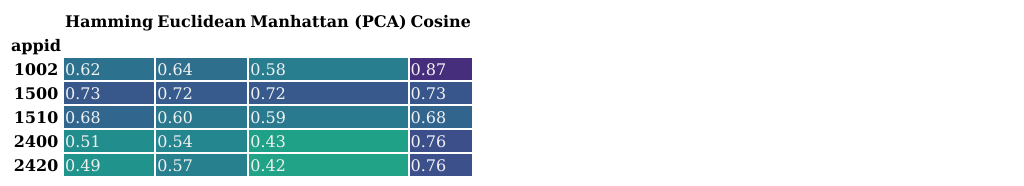

In [46]:
SVG('out.svg')

Notably, the approaches produce different distance distributions (as shown below). The takeaway from this figure is that cosine distances tend to be greater, but there is a long tail extending into the shorter distances.

This matches my expectations: given that games (like other media) tend to be pretty unique, higher degrees of similarity should be less likely, but still observed. 

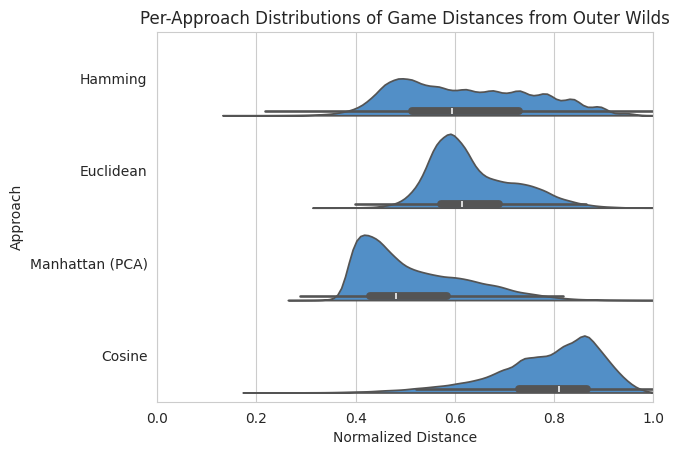

In [12]:
# Plots distribution of game distances from Outer-Wilds, per-approach
plot_similarities(df_distances_OW)

Next, let's look the top 5 "closest" games to Outer Wilds using each approach.

Notably, all approaches agree on "INFRA" and "Homesick" being in the top 5. Apart from those, most of these games look like they could _plausibly_ be similar to Outer Wilds, with the exception of "Spider: Rite of the Shrouded Moon." That happens to be my subjective judgement, so I'm not ready to make any decisions based on these lists alone. Let's look at another game. 

In [13]:
# Shows 5 closest games to Outer Wilds, per-approach
get_similar_games(df_distances_OW)

### Top 5 Games like Outer Wilds (per-Approach)

<style type="text/css">
#T_52ef7_row0_col0, #T_52ef7_row0_col1, #T_52ef7_row0_col3, #T_52ef7_row1_col2 {
  background-color: #98df8a;
  color: #000000;
}
#T_52ef7_row0_col2 {
  background-color: #e377c2;
  color: #f1f1f1;
}
#T_52ef7_row1_col0, #T_52ef7_row2_col1, #T_52ef7_row2_col2, #T_52ef7_row3_col3 {
  background-color: #c5b0d5;
  color: #000000;
}
#T_52ef7_row1_col1, #T_52ef7_row4_col3 {
  background-color: #ffbb78;
  color: #000000;
}
#T_52ef7_row1_col3 {
  background-color: #17becf;
  color: #000000;
}
#T_52ef7_row2_col0, #T_52ef7_row4_col1 {
  background-color: #8c564b;
  color: #f1f1f1;
}
#T_52ef7_row2_col3 {
  background-color: #ff9896;
  color: #000000;
}
#T_52ef7_row3_col0 {
  background-color: #bcbd22;
  color: #000000;
}
#T_52ef7_row3_col1 {
  background-color: #1f77b4;
  color: #f1f1f1;
}
#T_52ef7_row3_col2 {
  background-color: #7f7f7f;
  color: #f1f1f1;
}
#T_52ef7_row4_col0 {
  background-color: #aec7e8;
  color: #000000;
}
#T_52ef7_row4_col2 {
  background-color: #9edae5;
  color: #000000;
}
</style>
<table id="T_52ef7">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_52ef7_level0_col0" class="col_heading level0 col0" >Hamming</th>
      <th id="T_52ef7_level0_col1" class="col_heading level0 col1" >Euclidean</th>
      <th id="T_52ef7_level0_col2" class="col_heading level0 col2" >Manhattan (PCA)</th>
      <th id="T_52ef7_level0_col3" class="col_heading level0 col3" >Cosine</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_52ef7_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_52ef7_row0_col0" class="data row0 col0" >INFRA</td>
      <td id="T_52ef7_row0_col1" class="data row0 col1" >INFRA</td>
      <td id="T_52ef7_row0_col2" class="data row0 col2" >Spider: Rite of the Shrouded Moon</td>
      <td id="T_52ef7_row0_col3" class="data row0 col3" >INFRA</td>
    </tr>
    <tr>
      <th id="T_52ef7_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_52ef7_row1_col0" class="data row1 col0" >Homesick</td>
      <td id="T_52ef7_row1_col1" class="data row1 col1" >ALONE IN SPACE</td>
      <td id="T_52ef7_row1_col2" class="data row1 col2" >INFRA</td>
      <td id="T_52ef7_row1_col3" class="data row1 col3" >The Fall of Lazarus</td>
    </tr>
    <tr>
      <th id="T_52ef7_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_52ef7_row2_col0" class="data row2 col0" >Cradle</td>
      <td id="T_52ef7_row2_col1" class="data row2 col1" >Homesick</td>
      <td id="T_52ef7_row2_col2" class="data row2 col2" >Homesick</td>
      <td id="T_52ef7_row2_col3" class="data row2 col3" >Spirits of Xanadu</td>
    </tr>
    <tr>
      <th id="T_52ef7_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_52ef7_row3_col0" class="data row3 col0" >The Initiate</td>
      <td id="T_52ef7_row3_col1" class="data row3 col1" >The Station</td>
      <td id="T_52ef7_row3_col2" class="data row3 col2" >Rodina</td>
      <td id="T_52ef7_row3_col3" class="data row3 col3" >Homesick</td>
    </tr>
    <tr>
      <th id="T_52ef7_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_52ef7_row4_col0" class="data row4 col0" >The Turing Test</td>
      <td id="T_52ef7_row4_col1" class="data row4 col1" >Cradle</td>
      <td id="T_52ef7_row4_col2" class="data row4 col2" >Rebel Galaxy</td>
      <td id="T_52ef7_row4_col3" class="data row4 col3" >ALONE IN SPACE</td>
    </tr>
  </tbody>
</table>


### 2.2 - Slay the Spire
The approaches produce similar distance distributions for Slay the Spire as they did for Outer Wilds, though distances tend to be much higher overall. This makes sense; while I don't necessarily think Slay the Spire is more unique than Outer Wilds, it makes sense that its tags would be (Outer Wilds has some common tags like "Sci-Fi," "Space," etc.).

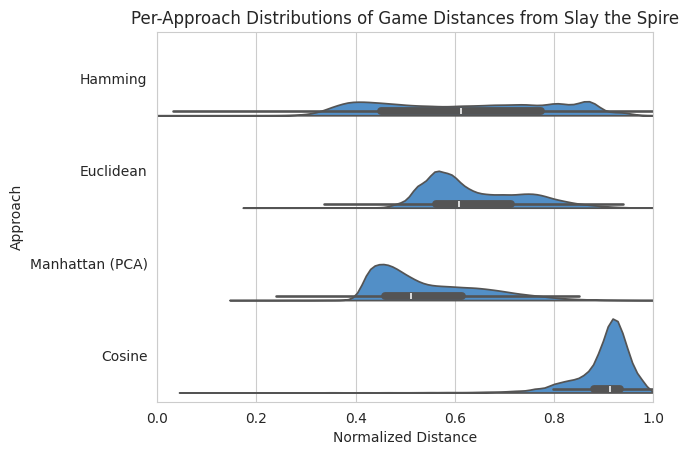

In [14]:
# Gets game distances from Slay the Spire
df_distances_StS = get_distances("Slay the Spire")

# Plots distribution of distances from Slay the Spire, per-approach
plot_similarities(df_distances_StS)

Again, looking at these lists of games, they all could plausibly be similar to the current reference game (Slay the Spire). A couple observations:
- All approaches agree on two games
- The Euclidean and Manhattan approaches produce identical lists (ignoring order)

We've only looked at two games, but I don't think looking at the 5 closest games from each approach will really show which is better: let's move on to the next evaluation.

In [15]:
# Gets 5 games closest to Slay the Spire, per-approach
get_similar_games(df_distances_StS)

### Top 5 Games like Slay the Spire (per-Approach)

<style type="text/css">
#T_f8220_row0_col0, #T_f8220_row0_col1, #T_f8220_row0_col2, #T_f8220_row2_col3 {
  background-color: #ff7f0e;
  color: #f1f1f1;
}
#T_f8220_row0_col3, #T_f8220_row1_col2, #T_f8220_row2_col1, #T_f8220_row4_col0 {
  background-color: #2ca02c;
  color: #f1f1f1;
}
#T_f8220_row1_col0 {
  background-color: #d62728;
  color: #f1f1f1;
}
#T_f8220_row1_col1, #T_f8220_row3_col2 {
  background-color: #1f77b4;
  color: #f1f1f1;
}
#T_f8220_row1_col3, #T_f8220_row2_col2, #T_f8220_row4_col1 {
  background-color: #bcbd22;
  color: #000000;
}
#T_f8220_row2_col0 {
  background-color: #7f7f7f;
  color: #f1f1f1;
}
#T_f8220_row3_col0 {
  background-color: #17becf;
  color: #000000;
}
#T_f8220_row3_col1, #T_f8220_row4_col2 {
  background-color: #8c564b;
  color: #f1f1f1;
}
#T_f8220_row3_col3 {
  background-color: #e377c2;
  color: #f1f1f1;
}
#T_f8220_row4_col3 {
  background-color: #9467bd;
  color: #f1f1f1;
}
</style>
<table id="T_f8220">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_f8220_level0_col0" class="col_heading level0 col0" >Hamming</th>
      <th id="T_f8220_level0_col1" class="col_heading level0 col1" >Euclidean</th>
      <th id="T_f8220_level0_col2" class="col_heading level0 col2" >Manhattan (PCA)</th>
      <th id="T_f8220_level0_col3" class="col_heading level0 col3" >Cosine</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_f8220_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_f8220_row0_col0" class="data row0 col0" >Fate Hunters</td>
      <td id="T_f8220_row0_col1" class="data row0 col1" >Fate Hunters</td>
      <td id="T_f8220_row0_col2" class="data row0 col2" >Fate Hunters</td>
      <td id="T_f8220_row0_col3" class="data row0 col3" >C.A.R.D.S. RPG: The Misty Battlefield</td>
    </tr>
    <tr>
      <th id="T_f8220_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_f8220_row1_col0" class="data row1 col0" >Spellsword Cards: Origins</td>
      <td id="T_f8220_row1_col1" class="data row1 col1" >Dicey Dungeons</td>
      <td id="T_f8220_row1_col2" class="data row1 col2" >C.A.R.D.S. RPG: The Misty Battlefield</td>
      <td id="T_f8220_row1_col3" class="data row1 col3" >Blood Card</td>
    </tr>
    <tr>
      <th id="T_f8220_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_f8220_row2_col0" class="data row2 col0" >月圆之夜 (Night of Full Moon)</td>
      <td id="T_f8220_row2_col1" class="data row2 col1" >C.A.R.D.S. RPG: The Misty Battlefield</td>
      <td id="T_f8220_row2_col2" class="data row2 col2" >Blood Card</td>
      <td id="T_f8220_row2_col3" class="data row2 col3" >Fate Hunters</td>
    </tr>
    <tr>
      <th id="T_f8220_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_f8220_row3_col0" class="data row3 col0" >Legend of PC</td>
      <td id="T_f8220_row3_col1" class="data row3 col1" >Coin Crypt</td>
      <td id="T_f8220_row3_col2" class="data row3 col2" >Dicey Dungeons</td>
      <td id="T_f8220_row3_col3" class="data row3 col3" >Perfect Teams</td>
    </tr>
    <tr>
      <th id="T_f8220_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_f8220_row4_col0" class="data row4 col0" >C.A.R.D.S. RPG: The Misty Battlefield</td>
      <td id="T_f8220_row4_col1" class="data row4 col1" >Blood Card</td>
      <td id="T_f8220_row4_col2" class="data row4 col2" >Coin Crypt</td>
      <td id="T_f8220_row4_col3" class="data row4 col3" >Acolyte of the Altar</td>
    </tr>
  </tbody>
</table>


## 3. Similarity Approach Comparison - Game Pairs
It's impossible to evaluate these approaches objectively, but rather than ask whether the games they think are "closest" to some reference game are actually most similar, we can see how they rank certain pairs of games.

For this comparison, I've selected pairs of games I'm familiar with, and I would judge to be significantly more/less similar than other pairs in the comparison.

In [16]:
# Generates comparison DataFrame

# Generates list of tuples of games to be compared
list_comparisons = [
    ("Satisfactory", "Factorio"),
    ("OMORI", "Undertale"),
    ("Stardew Valley", "Don't Starve"),
    ("GRIS", "Rust"),
]

# Instantiates empty DataFrame to hold distances per pair/approach combination
df_approach_comparison = pd.DataFrame()

# Iterates through game pairs...
for reference_game, comparison_game in list_comparisons:
    # Gets distances of all games from first game of current comparison for all methods...
    df_distances_reference = get_distances(reference_game)

    # Gets per-approach distances of second game of current comparison from first game
    distances_current = df_distances_reference.loc[dict_appids[comparison_game]]

    # Adds distances to DataFrame of all comparisons
    df_approach_comparison[reference_game + " & " + comparison_game] = distances_current

# Melts comparison DataFrame into appropriate shape (for ease of plotting with Seaborn)
df_approach_comparison = df_approach_comparison.reset_index().melt(
    id_vars="index", var_name="Game Pair", value_name="Normalized Distance"
)

In descending order of similarity:
- "Satisfactory" & "Factorio": Highly similarity; games about base building and optimizing production chains
- "OMORI" & "Undertale": Medium similarity; high-quality RPGMaker games, but OMORI has a strong psychological horror angle
- "Stardew Valley" & "Don't Starve": Low similarity; they both feature crafting as a core mechanic and have well-liked 2D art styles, but that's about it.
- "GRIS & Rust": No similarity; GRIS is a beautiful 2D platformer about dealing with grief, and RUST is a multiplayer sandbox.

As the figure below illustrates, the cosine distances of these game pairs exactly matches my ranking of their similarities. (In the absence of cosine distance, I might judge the results of Euclidean distance to be acceptable.)

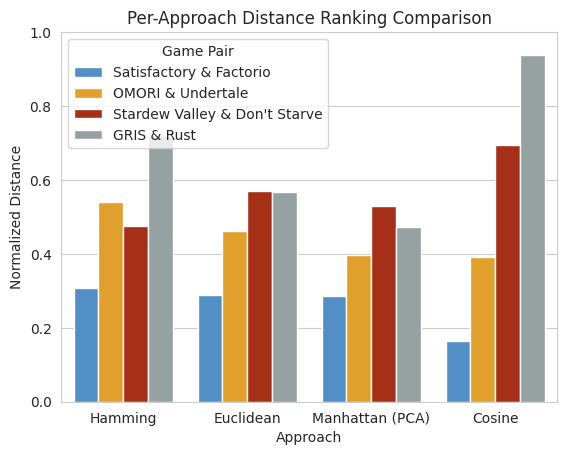

In [17]:
# Plots comparisons
# Draws plot
ax = sns.barplot(
    df_approach_comparison, x="index", y="Normalized Distance", hue="Game Pair"
)

# Formats plot
sns.move_legend(ax, "upper left")
plt.ylim(0, 1)
plt.xlabel("Approach")
plt.title("Per-Approach Distance Ranking Comparison")
plt.show()

## 3. Conclusion
If it were possible to objectively determine which games were most similar then this notebook wouldn't be necessary; the objective distance metric that best matches my subjective understanding of game similarity is cosine distance.
- Cosine distance distributions reflect that games are more likely to be less similar
- The 5 games with the lowest cosine distance from some reference game look plausibly similar to that reference game (though the same could be said of the other approaches)
- Given four game pairs of "known" similarity (high, medium, low, none), the cosine distances of those pairs tracked their similarity ranks better than other distances.

## 4. Appendix
I only used PCA in the Manhattan approach because:
- The Hamming-inspired approach was supposed to be the naive solution; complicating it would have defeated the point... it would also be nearly identical to the Manhattan approach 
- Euclidean distances are the same pre- and post-PCA
- Cosine distance gave identical results with/without PCA (post-normalization)